In [1]:
"""
compare.py - Model Comparison Framework

This module provides functions to load data, split it into train/test sets,
and compare the performance of different classification models.
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Import our model implementations
from logistic import run_logistic_regression
from nnmodel import run_neural_network
from random_forest import run_random_forest


In [2]:

def load_data(file_path, target_column=None):
    # Load the data
    try:
        data = pd.read_csv(file_path)
        print(f"Successfully loaded data with shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None
    
    # If target column is not specified, use the last column
    if target_column is None:
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
    else:
        X = data.drop(target_column, axis=1)
        y = data[target_column]
    
    return X, y


In [3]:
def preprocess_data(X, y, test_size=0.2, random_state=42, scale=True):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale numeric features if requested
    if scale:
        # Identify binary columns (starting with 'weather_' or 'sex_')
        binary_cols = [col for col in X_train.columns if col.startswith(('weather_', 'sex_'))]
        numeric_cols = [col for col in X_train.columns if col not in binary_cols]
        
        if len(numeric_cols) > 0:
            print(f"Scaling numeric columns: {numeric_cols}")
            scaler = StandardScaler()
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            
            X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
            
            X_train, X_test = X_train_scaled, X_test_scaled
    
    print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [4]:

def compare_models(X_train, X_test, y_train, y_test, models=['logistic']):
    results = {}
    
    # Run models based on the list provided
    for model_name in models:
        if model_name.lower() == 'logistic':
            print("Running Logistic Regression...")
            logimodel, logimodel_results = run_logistic_regression(X_train, y_train, X_test, y_test)
            results['logistic'] = logimodel_results
        if model_name.lower() == 'nn':
            print("Running Neural Network...")
            nnmodel, nnmodel_results = run_neural_network(X_train, y_train, X_test, y_test)
            results['nn'] = nnmodel_results
        if model_name == 'rf':
            model, rfmodel_results = run_random_forest(X_train, y_train, X_test, y_test)
            results['rf'] = rfmodel_results

        
    return results


In [5]:

def visualize_results(results):
    """
    Visualize the results from different models
    
    Args:
        results: Dictionary of results for each model
    """
    # Bar chart for accuracy, precision, recall, f1
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = list(results.keys())
    
    metrics_data = {metric: [results[model][metric] for model in models] for metric in metrics}
    # Print metrics for each model
    print("\n--- Model Performance Metrics ---")
    for model in models:
        print(f"\n{model.upper()} RESULTS:")
        for metric in metrics:
            print(f"{metric}: {results[model][metric]:.4f}")
        
        # Print additional metrics if available
        if 'accuracy' in results[model]:
            print(f"Accuracy: {results[model]['accuracy']:.4f}")
        if 'precision' in results[model]:
            print(f"Precision: {results[model]['precision']:.4f}")
        if 'recall' in results[model]:
            print(f"Recall: {results[model]['recall']:.4f}")
        if 'f1_score' in results[model]:
            print(f"F1 Score: {results[model]['f1_score']:.4f}")
        if 'confusion_matrix' in results[model]:
            print(f"Confusion Matrix:\n{results[model]['confusion_matrix']}")
    # Create the plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(x + i*bar_width, metrics_data[metric], width=bar_width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + bar_width*1.5, models)
    plt.legend()
    plt.tight_layout()
    
    
    # For each model, plot confusion matrix
    for model_name, model_results in results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        # plt.savefig(f'confusion_matrix_{model_name}.png')
        # print(f"Confusion matrix for {model_name} saved")


In [6]:

def main(data_path, target_column=None):
    # Load data
    X, y = load_data(data_path, target_column)
    
    if X is None or y is None:
        print("Failed to load data. Exiting.")
        return
    
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(X, y)
    
    # Run models
    model_results = compare_models(X_train, X_test, y_train, y_test, models=['logistic', 'nn', 'rf'])
    
    # Visualize results
    visualize_results(model_results)
    
    print("Analysis complete!")


Successfully loaded data with shape: (18517, 14)
Scaling numeric columns: ['Weight (kg)', 'Horse Weight (kg)', 'average_time', 'Age']
Train set shape: (14813, 13), Test set shape: (3704, 13)
Running Logistic Regression...
Running Neural Network...
Epoch 10/100, Loss: 1.2561
Epoch 20/100, Loss: 1.2442
Epoch 30/100, Loss: 1.2378
Epoch 40/100, Loss: 1.2303
Epoch 50/100, Loss: 1.2142
Epoch 60/100, Loss: 1.2021
Epoch 70/100, Loss: 1.2076
Epoch 80/100, Loss: 1.1825
Epoch 90/100, Loss: 1.1824
Epoch 100/100, Loss: 1.1700

--- Model Performance Metrics ---

LOGISTIC RESULTS:
accuracy: 0.5130
precision: 0.8934
recall: 0.5130
f1_score: 0.6282
Accuracy: 0.5130
Precision: 0.8934
Recall: 0.5130
F1 Score: 0.6282
Confusion Matrix:
[[1763 1708]
 [  96  137]]

NN RESULTS:
accuracy: 0.5243
precision: 0.0731
recall: 0.5622
f1_score: 0.1294
Accuracy: 0.5243
Precision: 0.0731
Recall: 0.5622
F1 Score: 0.1294
Confusion Matrix:
[[1811 1660]
 [ 102  131]]

RF RESULTS:
accuracy: 0.9303
precision: 0.8803
recall: 

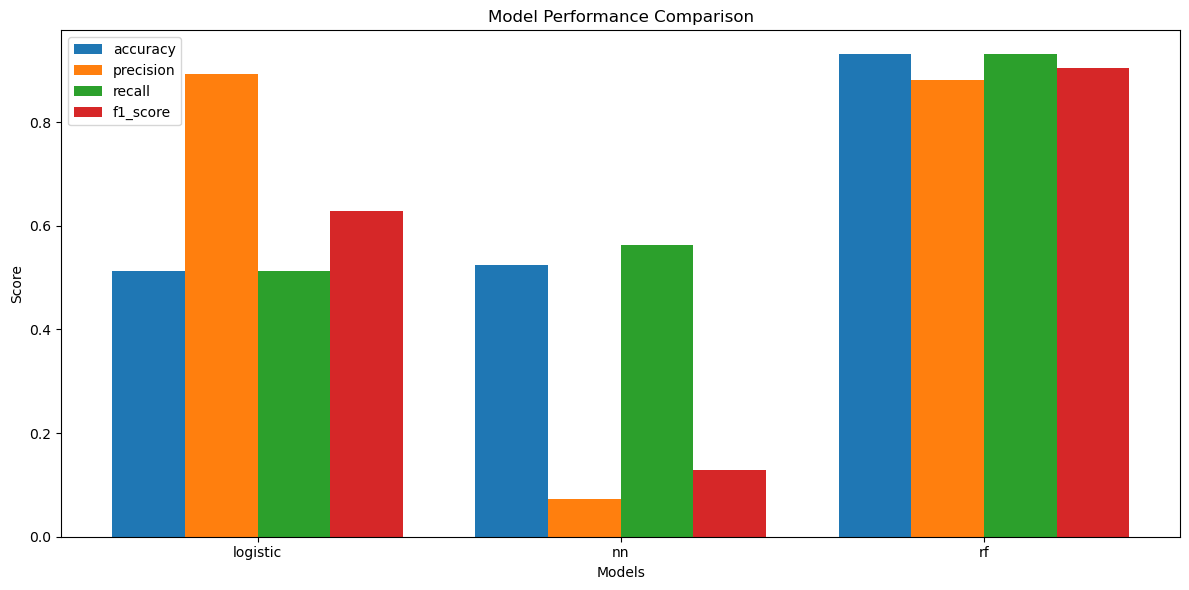

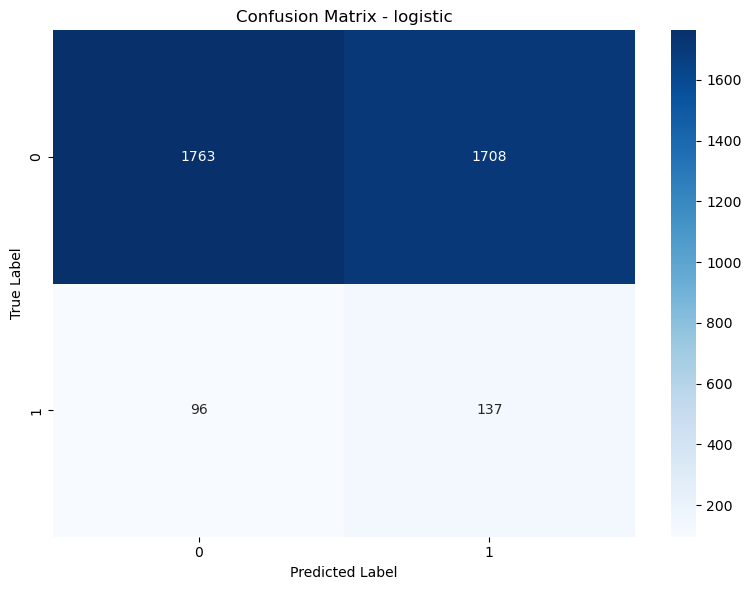

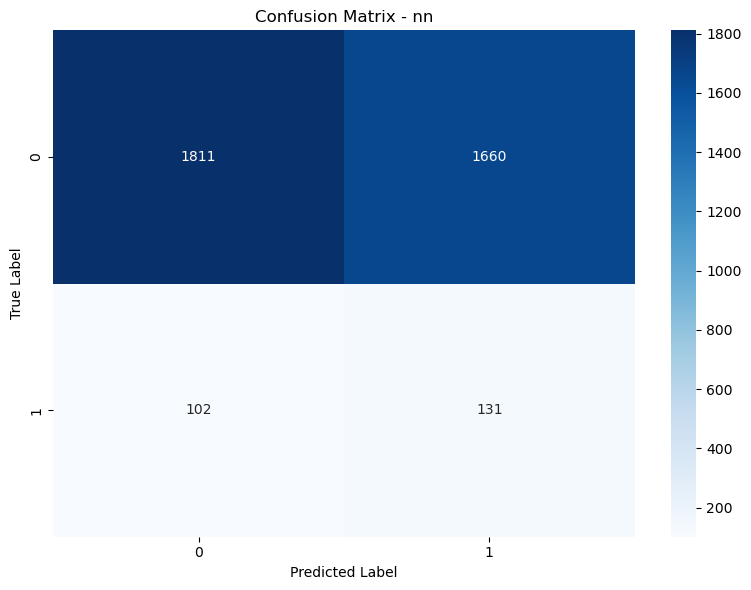

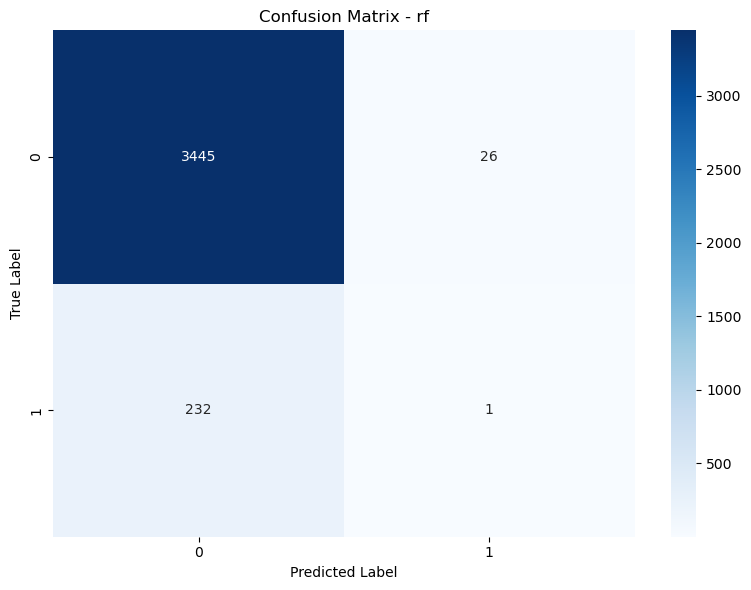

In [7]:
main('data/processed_race_results.csv', 'is_top1')
